<h1>Predicting Cloting Retail Sales using LSTM</h1>
<h3>Dataset Details</h3>
<ul>
    <li>Dataset Title : Retail Sales: Clothing and Clothing Accessory Stores</li>
    <li>Dataset Source : Fred Economic Data</li>
    <li>Weblink : https://fred.stlouisfed.org/series/MRTSSM448USN</li>
    <li>Original Dataset from : U.S. Census Bereau</li>
    <li>Dataset last updated : 01 March, 2020</li>
    <li>Description: Monthly clothing sales data from 1992-01-01 to 2020-03-01</li>
</ul>    

In [1]:
#import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 339 entries, 1992-01-01 to 2020-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   339 non-null    int64
dtypes: int64(1)
memory usage: 5.3 KB
None


,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


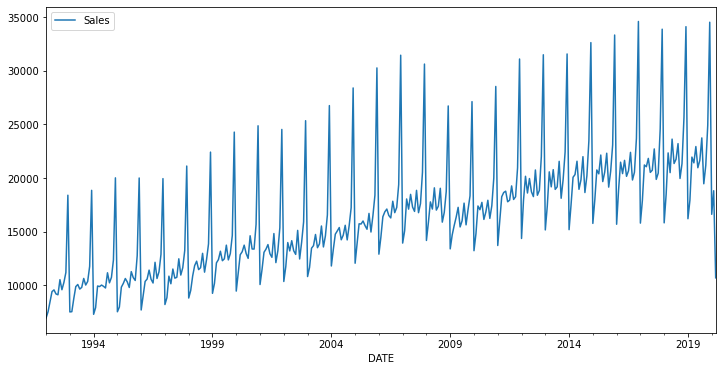

In [21]:
#load data and plot data
df = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=MRTSSM448USN&scale=left&cosd=1992-01-01&coed=2020-03-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2020-05-16&revision_date=2020-05-16&nd=1992-01-01')
df.rename(columns={'MRTSSM448USN':'Sales'}, inplace=True)
df['DATE'] = df['DATE'].astype('datetime64[ns]') 
df.set_index('DATE', drop=True, inplace=True)

print(df.info())
display(df.head())
df.plot(figsize=(12,6))

In [22]:
#split into training and testing data
print('total entries = ', len(df))

test_size = 18
test_ind = len(df)-18

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

display(train.head())
print('Train shape : ',train.shape)
display(test.head())
print('Train shape : ',test.shape)

total entries =  339


,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


Train shape :  (321, 1)


,Sales
DATE,
2018-10-01,21337
2018-11-01,25652
2018-12-01,34125
2019-01-01,16201
2019-02-01,17932


Train shape :  (18, 1)


In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
#scale the input values to between 0 and 1
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [26]:
#create a time series generator taking 12 values and predicting next 1 value
length = 12
generator = TimeseriesGenerator(scaled_train, 
                                scaled_train, 
                                length=length, 
                                batch_size=1)

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02117588 0.0555415  0.08900372 0.09467712 0.08108987
 0.0782351  0.12918729 0.09521917 0.11982799 0.15354316 0.41401366]
Predict this y: 
 [[0.02038088]]


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [30]:
#create the test model
n_features = 1

def testmodel():
    model = Sequential()
    model.add(LSTM(units=100, activation='relu', input_shape=(length, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    return model

modeltest = testmodel()
print(modeltest.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
#add an early stop => stop training if validation loss decreases for continuously 2 times
early_stop = EarlyStopping(monitor='val_loss',patience=2)

validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test, 
                                           length=length, 
                                           batch_size=1)

In [34]:
#fit the generator to model
modeltest.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Train for 309 steps, validate for 6 steps
Epoch 1/20
309/309 [==============================] - 7s 22ms/step - loss: 0.0247 - val_loss: 0.0711
Epoch 2/20
309/309 [==============================] - 4s 14ms/step - loss: 0.0168 - val_loss: 0.0549
Epoch 3/20
309/309 [==============================] - 5s 15ms/step - loss: 0.0106 - val_loss: 0.0425
Epoch 4/20
309/309 [==============================] - 4s 14ms/step - loss: 0.0055 - val_loss: 0.0518
Epoch 5/20
309/309 [==============================] - 4s 14ms/step - loss: 0.0026 - val_loss: 0.0276
Epoch 6/20
309/309 [==============================] - 4s 14ms/step - loss: 0.0015 - val_loss: 0.0300
Epoch 7/20
309/309 [==============================] - 5s 16ms/step - loss: 0.0025 - val_loss: 0.0284


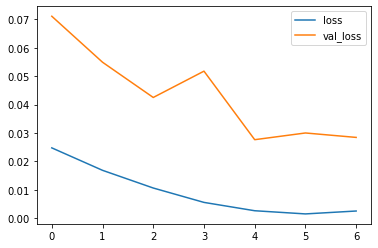

In [36]:
#create a losses dataframe and plot it
losses = pd.DataFrame(modeltest.history.history)
losses.plot()
plt.show()

In [38]:
#make prediction on the timestamps of test dataframe
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = modeltest.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Sales,Predictions
DATE,,
2018-10-01,21337,21062.683443
2018-11-01,25652,25089.519071
2018-12-01,34125,34937.579092
2019-01-01,16201,16741.794842
2019-02-01,17932,18921.564386


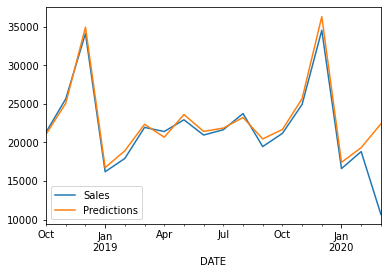

In [40]:
#rescale the predictions and plot along with true values
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
display(test.head())
test.plot()
plt.show()

<h1>Retrain and Forecasting</h1>
<h3>Train using the entire dataset.</h3>

In [41]:
#scale the data
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [42]:
#create a generator
length = 12
generator_final = TimeseriesGenerator(scaled_full_data, 
                                scaled_full_data, 
                                length=length, 
                                batch_size=1)

In [43]:
#create the final model
def finalmodel():
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    return model

modelfinal = finalmodel()

In [44]:
#fit generator to model
modelfinal.fit_generator(generator_final, epochs = 10)

Train for 327 steps
Epoch 1/10
327/327 [==============================] - 5s 16ms/step - loss: 0.0236
Epoch 2/10
327/327 [==============================] - 4s 13ms/step - loss: 0.0175
Epoch 3/10
327/327 [==============================] - 4s 13ms/step - loss: 0.0098
Epoch 4/10
327/327 [==============================] - 4s 13ms/step - loss: 0.0065
Epoch 5/10
327/327 [==============================] - 4s 13ms/step - loss: 0.0032
Epoch 6/10
327/327 [==============================] - 4s 12ms/step - loss: 0.0025
Epoch 7/10
327/327 [==============================] - 4s 13ms/step - loss: 0.0023
Epoch 8/10
327/327 [==============================] - 4s 13ms/step - loss: 0.0023
Epoch 9/10
327/327 [==============================] - 4s 13ms/step - loss: 0.0022
Epoch 10/10
327/327 [==============================] - 5s 14ms/step - loss: 0.0025


In [50]:
#predict the future values
forecast = []
periods = 36

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = modelfinal.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [51]:
#rescale the predictions and assign them the correct date range
forecast = scaler.inverse_transform(forecast)

forecast_index = pd.date_range(start='2020-04-01',periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

display(forecast_df.head())

,Forecast
2020-04-01,20779.440071
2020-05-01,22058.438423
2020-06-01,20399.385331
2020-07-01,21086.440318
2020-08-01,23082.037589


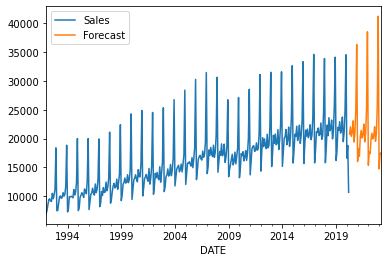

In [52]:
#plot the entire dataset and predictions
ax = df.plot()
forecast_df.plot(ax=ax)

(564.0, 639.0)

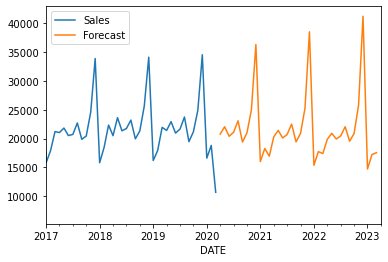

In [53]:
#plot a range of 6 years only for better visualisation
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2017-01-01','2023-4-01')

<h3>It is eident from the plots that the major trends in the time series data were preserved in the predictions also.<h3>
<h4>The peak appears during december every year.</h4>
<h4>The general trend that overall sales increase every year is also preserved.</h4>